# Libraries

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy.stats as st
import colorednoise as cn
from sklearn.metrics import accuracy_score #здесь accuracy - плохая метрика, потому что классы несбалансированные
from sklearn.metrics import f1_score #f1 рассчитывается для класса 1
from sklearn.metrics import auc, precision_recall_curve
from sklearn.mixture import GaussianMixture
from sklearn.metrics import balanced_accuracy_score
import tensorflow as tf
import ruptures as rpt
import colorednoise
import catboost
from catboost import Pool
import random
from random import shuffle
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

# CIR

In [4]:
def colored_noise(beta, size):
        noise_sample = cn.powerlaw_psd_gaussian(beta, size)

        return noise_sample

In [5]:
class Binary_Telegraph_Process:
    """
    Инициализация телеграфного процесса
    :param size: размер выборки
    :param f: функция ошибки
    :param p1: матожидание ошибки в случае np.random.normal, low в случае np.random.uniform, alpha в случае np.random.beta
    :param p2: дисперсия ошибки в случае np.random.normal, high в случае np.random.uniform, beta в случае np.random.beta
    """

    def __init__(self, size, p1=None, p2=None, p3=None, RANDOM_SEED=1234, no_error=False):
        self.size = size
        self.p1   = p1
        self.p2   = p2
        self.p3   = p3
        self.RANDOM_SEED   = RANDOM_SEED
        self.no_error = no_error

    def errors(self):
        if self.p1 == 'ECG':
            dir_ = 'sample_2.csv'
            #no file full_ecg.csv
            return pd.read_csv(dir_)["X"].values[::24]
        else:
            if self.p1 == None:
                return self.f
            elif self.p2 == None:
                return self.f(self.p1, size=self.size)
            elif self.p3 == None:
                return self.f(self.p1, self.p2, self.size)
            else:
                return self.f(self.p1, self.p2, self.p3, self.size)


    def estimate_kappa(self, r):
        n = len(r)
        numerator = (n-1)*np.sum([r[i]/r[i-1] for i in range(1,n)]) - np.sum(r[1:])*np.sum([i**(-1) for i in r[:-1]])
        denominator = (n-1)**2 - np.sum(r[:-1])*np.sum([i**(-1) for i in r[:-1]])
        kappa_hat = -np.log(numerator/denominator)
        return kappa_hat
    

    def estimate_theta(self, r, fl = 0, kappa_hat = 0):
        kappa_hat = self.estimate_kappa(r)
        n = len(r)
        theta_hat = (1/(n-1))*np.sum(r[1:]) + (np.exp(-kappa_hat)*(r[-1]-r[0]))/((n-1)*(1-np.exp(-kappa_hat)))
        return theta_hat

    def estimate_sigma(self,r): # sigma square
        kappa_hat = self.estimate_kappa(r)
        theta_hat = self.estimate_theta(r)
        n = len(r)
        numerator = 0
        denominator = 0
        reciprocal = [x**(-1) for x in r]
        
        numerator = np.sum([reciprocal[i-1] * (r[i] - r[i-1]*np.exp(-kappa_hat) - theta_hat*(1-np.exp(-kappa_hat)))**2 for i in range(1, n)])
        denominator += np.sum([reciprocal[i-1] * ((theta_hat/2 - r[i-1])*np.exp(-2*kappa_hat) - (theta_hat - r[i-1])*np.exp(-kappa_hat) + theta_hat/2)/kappa_hat for i in range(1, n)])
        sigma_hat = numerator/denominator
        return sigma_hat

    def get_data(self, size, beta, delt_t, hd, scheme, revalEnabled, alpha = 1):

        kappa = self.estimate_kappa(hd)
        theta = self.estimate_theta(hd)
        sigma = self.estimate_sigma(hd)

        components = pd.DataFrame()
        np.random.seed(self.RANDOM_SEED)
        data = []
        theta_list = []
        kappa_list = []
        sigma_list = []
        
        i = 0
        x_t = 0
        r_t = hd[-1] # последнее значение ставки в эмпирических данных

        dt = delt_t
        error_part = []

        # if beta != 0:
        #     errors = colored_noise(beta, size)*alpha
        # else:
        #     errors = np.sqrt(dt) * np.random.normal(loc=0, scale=1, size=size)

        errors = colored_noise(beta, size)*alpha

        while i < size:
            
#             Метод Эйлера для CIR:
#             r_t = r_t + kappa*(theta - r_t)*dt + np.sqrt(sigma*dt*r_t)*W[i]
            
#             В рамках исследования заменяем W[i] на цветной шум

            if scheme == 'euler': # заменяем винеровский процесс на шум
                r_t = r_t + kappa*(theta - r_t)*dt + np.sqrt(sigma*r_t*dt)*errors[i]
            elif scheme == 'euler_max': # r_t заменяем на max(r_t, 0)
                r_t = r_t + kappa*(theta - max(0, r_t))*dt + np.sqrt(sigma*max(0, r_t)*dt)*errors[i]
            elif scheme == 'milstein':
                r_t = r_t + kappa*(theta - r_t)*dt + np.sqrt(sigma*r_t*dt)*errors[i] + 0.25*sigma*dt*((errors[i])**2 - 1)
            elif scheme == 'implicit_milstein':
                r_t = (r_t + kappa*theta*dt + np.sqrt(sigma*r_t*dt)*errors[i] + 0.25*sigma*dt*((errors[i])**2 - 1))/(1+kappa*dt)

            if r_t < 0:
                print(f'Отрицательное значение ставки:\n r_t = {r_t},\n i = {i},\n kappa = {kappa},\n theta = {theta},\n sigma = {sigma},\n error = {errors[i]}')
                return
            
            data.append(r_t)
    
            theta_list.append(theta)
            kappa_list.append(kappa)
            sigma_list.append(sigma)
            error_part.append(errors[i])
            
            if revalEnabled == 1: # переоценка
                kappa = self.estimate_kappa(hd+data)
                theta = self.estimate_theta(hd+data)
                sigma = self.estimate_sigma(hd+data)

            i += 1

        return data, theta_list, kappa_list, sigma_list, error_part


    def labels(self):
        labels = [] #разметка данных: 1 если был переход, 0 если не было
        labels.append(0) #первый элемент не с чем сравнивать, по умолчанию без перехода
        data = self.clusters()
        for i in range(1, data.shape[0]):
            if data.iloc[i][1] != data.iloc[i-1][1]:
                labels.append(1)
            else:
                labels.append(0)
        data['MARKS'] = labels
        return data

In [6]:
hd = pd.read_csv('monthlyIR.csv')

hd_list = list(hd['value'])

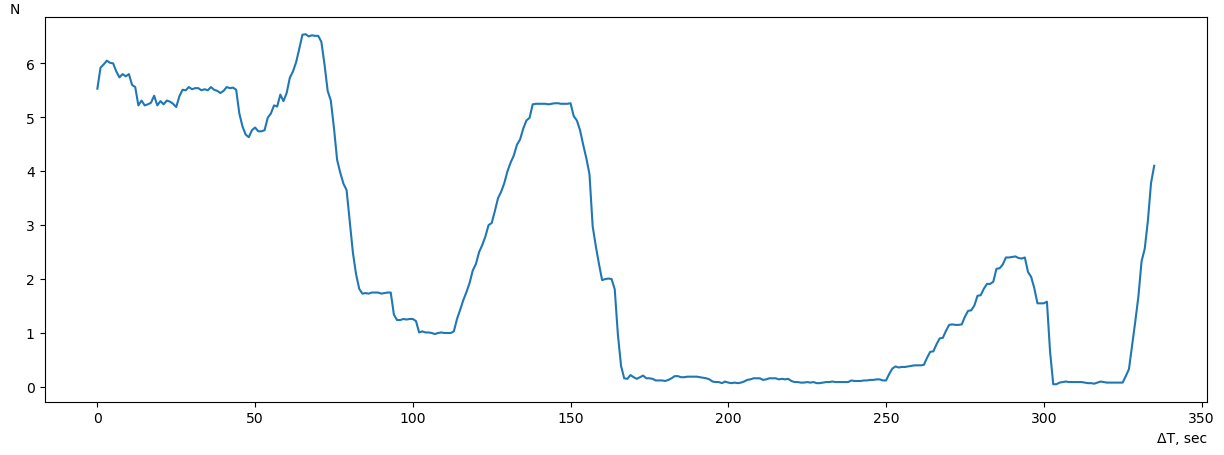

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(hd_list)
plt.xlabel('ΔT, sec', loc = 'right')
plt.ylabel('N', loc='top', rotation = 'horizontal')
# plt.axhline(y=thett[0], color='r', linestyle='-')

plt.show()

# Генерация ряда

In [35]:
length = 1000

bp = Binary_Telegraph_Process(length, RANDOM_SEED=[np.random.randint(1,1000)])
# bp = Binary_Telegraph_Process(length, RANDOM_SEED=[34567])

In [46]:
# шаг интеграции
dt = 0.0001

data, thett, kapp, sigg, err = bp.get_data(length, 0, dt, hd_list, scheme = 'implicit_milstein', revalEnabled = 0, alpha = 1)

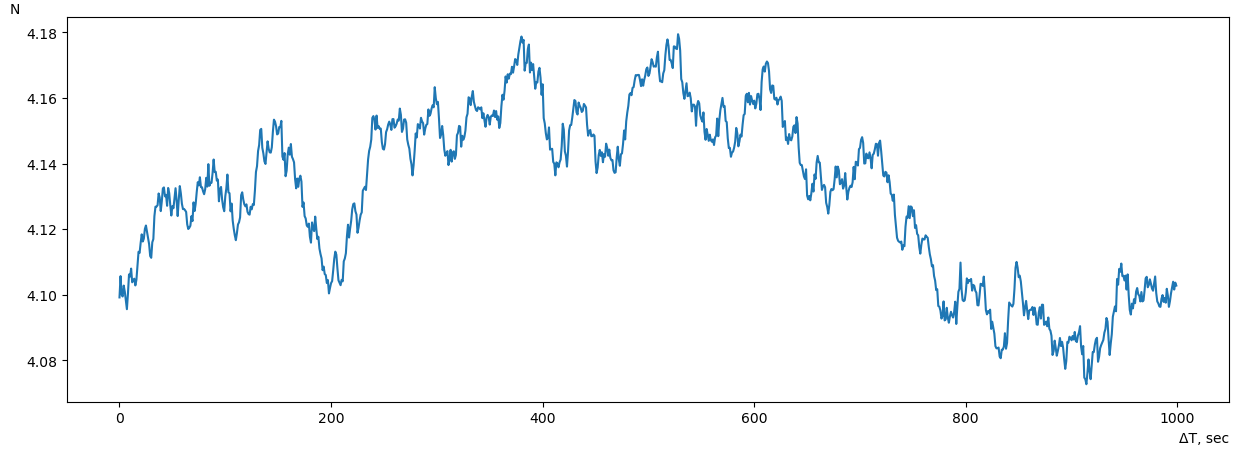

In [47]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(data)
plt.xlabel('ΔT, sec', loc = 'right')
plt.ylabel('N', loc='top', rotation = 'horizontal')
# plt.axhline(y=thett[0], color='r', linestyle='-')

plt.show()

# Разметка ряда

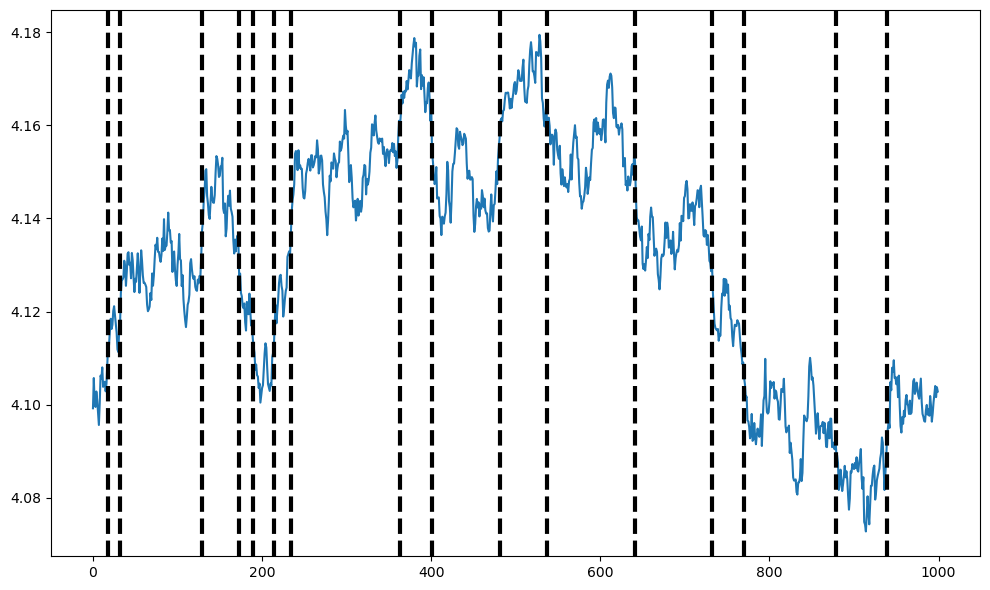

In [54]:
# If you expect only mean shifts, use "l2".
# If your data is highly non-linear, try "rbf".
# If you want to detect trends, use "linear".
# If both mean and variance change, go for "normal".
# If you have multivariate data, consider "clinear".

sign = []

for i in range(len(data)):
    temp = np.array([data[i]])
    sign.append(temp)

sign = np.array(sign)

model = "rbf"  # "l2", "rbf"

algo = rpt.Pelt(model = model, jump = 1).fit(sign)
my_bkps = algo.predict(pen=(0.5*np.log(1000)))

fig, ax_arr = rpt.display(sign,[1], my_bkps, figsize=(10, 6))
plt.show()

In [55]:
# индексы точек перехода

print(my_bkps)

[18, 33, 129, 173, 190, 215, 235, 364, 401, 482, 537, 642, 733, 770, 879, 939, 1000]


# Подготовка данных

In [56]:
def bigdata(n, length, dt, noise, hd_list):
    bigdata = []
    for i in range(n):
        bp = Binary_Telegraph_Process(length, RANDOM_SEED=[np.random.randint(1, 1000)])
        data, thett, kapp, sigg, err = bp.get_data(length, noise, dt, hd_list, scheme = 'implicit_milstein', revalEnabled = 0, alpha = 1)
        bigdata.append(data)
        
    return bigdata

In [57]:
# Функция, которая преобразовывает ряд и передает фичи (все наблюдения) и таргеты (наблюдения, где была точка перехода)

def data_reshape(data):
  model = "rbf"
  tar = []
  features = []

  for i in range(len(data)):

    temp_dat = data[i]
    tmep_bkps = []

    sign = []

    for j in range(len(temp_dat)):
      temp = np.array([temp_dat[j]])
      sign.append(temp)

    sign = np.array(sign)

#     print(sign)

    algo = rpt.Pelt(model = model, jump = 5).fit(sign)
    my_bkps = algo.predict(pen=(0.5*np.log(length)))

    temp_tar = []

    for k in range(len(data[i])):
      if k in my_bkps:
        temp_tar.append(1)
      else:
        temp_tar.append(0)

    tar += temp_tar
    features += data[i]

  return features, tar

In [58]:
# Подготовка выборки

def train_test_split(data, target, percent, window):
    end_data = round(len(data)*percent)
    start_data = end_data - window

    end_targ = round(len(target)*percent)
    start_targ = end_targ - window


    X_train = data[0:end_data]
#     X_train = [[i] for i in X_train]
    X_train = [i for i in X_train]
    X_train = np.array(X_train)
    X_test = data[start_data:]

    Y_train = target[0:end_targ]
#     Y_train = [[i] for i in Y_train]
    Y_train = [i for i in Y_train]
    Y_train = np.array(Y_train)
    Y_test = target[start_targ:]

    return X_train, X_test, Y_train, Y_test


In [59]:
# Вспомогательная функция

def data_reshape_diff_balanced_eta_pi(sample, target, window, eta):
    features_set_0 = [] #хранит массив 1*window предыдущих чисел для класса 0
    features_set_1 = [] #хранит массив 1*window предыдущих чисел для класса 1
    for i in range(window+1, sample.shape[0]):
        if 1 in target[i:i+eta]:
          features_set_1.append(sample[i-window:i] - sample[i-(window+1):i-1]) #начинает идти с 0, потом с 1, потом с 2 и тд до i невключительно
        else:
          features_set_0.append(sample[i-window:i] - sample[i-(window+1):i-1]) #начинает идти с 0, потом с 1, потом с 2 и тд до i невключительно
    #features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
    levels_0 = [0] * len(features_set_0) # кол-во 0-вых наблюдений
    levels_1 = [1] * len(features_set_1) # кол-во точек перехода
    return features_set_0, features_set_1, levels_0, levels_1

In [60]:
# Готовит данные для подачи в модельку (сбалансированная выборка)

def data_prep(features_set_0, features_set_1, levels_0, levels_1):
  features = []
  levels = []
  for i in range(len(features_set_1)):
    features.append(features_set_1[i])
    levels.append(1)
    features.append(random.choice(features_set_0))
    levels.append(0)

  features, levels = np.array(features), np.array(levels)
  return features, levels

# Catboost

In [83]:
data = bigdata(n = 100, length = 1000, dt = 0.0001, noise = -2, hd_list = hd_list)
features, tar = data_reshape(data)
features_set_0, features_set_1, levels_0, levels_1 = data_reshape_diff_balanced_eta_pi(np.array(features), np.array(tar), 100, 1)
features_deff_bl, levels_deff_bl = data_prep(features_set_0, features_set_1, levels_0, levels_1)
X_train, X_validation, y_train , y_validation = train_test_split(features_deff_bl, levels_deff_bl, 0.8, 100)

In [84]:
model = CatBoostClassifier(iterations = 100, learning_rate = 0.1, loss_function = "Logloss", custom_loss = ["AUC", "Accuracy"])

model.fit(X_train, y_train, eval_set = (X_validation, y_validation), verbose = True, plot = False)

print("Model is fitted: " + str(model.is_fitted()))
print('Model params: ')
print(model.get_params())

0:	learn: 0.6659687	test: 0.6775830	best: 0.6775830 (0)	total: 10.6ms	remaining: 1.05s
1:	learn: 0.6437566	test: 0.6660934	best: 0.6660934 (1)	total: 20.9ms	remaining: 1.02s
2:	learn: 0.6126229	test: 0.6433736	best: 0.6433736 (2)	total: 30.2ms	remaining: 976ms
3:	learn: 0.5841113	test: 0.6271979	best: 0.6271979 (3)	total: 39.8ms	remaining: 955ms
4:	learn: 0.5651252	test: 0.6131859	best: 0.6131859 (4)	total: 48.8ms	remaining: 927ms
5:	learn: 0.5364595	test: 0.5968962	best: 0.5968962 (5)	total: 58.4ms	remaining: 915ms
6:	learn: 0.5231416	test: 0.5887141	best: 0.5887141 (6)	total: 68.5ms	remaining: 910ms
7:	learn: 0.5033015	test: 0.5762204	best: 0.5762204 (7)	total: 77.2ms	remaining: 888ms
8:	learn: 0.4847076	test: 0.5661902	best: 0.5661902 (8)	total: 86ms	remaining: 870ms
9:	learn: 0.4581609	test: 0.5564472	best: 0.5564472 (9)	total: 94.4ms	remaining: 850ms
10:	learn: 0.4425532	test: 0.5437719	best: 0.5437719 (10)	total: 103ms	remaining: 834ms
11:	learn: 0.4267262	test: 0.5364316	best: 0

# Метрики

In [85]:
# Метрики

eval_pool = Pool(X_validation, y_validation)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

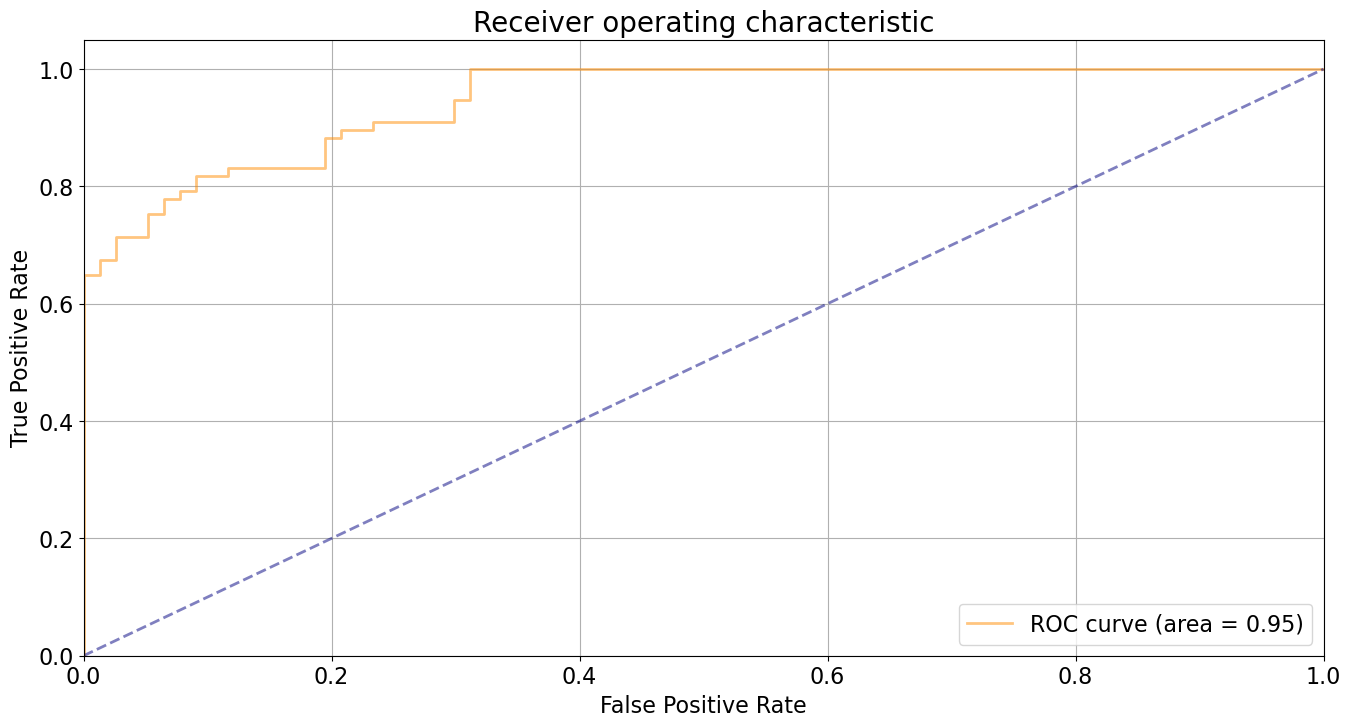

In [86]:
# ROC-AUC curve

plt.figure(figsize=(16,8))
lw = 2

plt.plot(fpr,tpr,color = 'darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc, alpha = 0.5)

plt.plot([0,1], [0,1], color = 'navy', lw = lw, linestyle = "--", alpha = 0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver operating characteristic', fontsize = 20)
plt.legend(loc = 'lower right', fontsize = 16)
plt.show()

In [87]:
# забираем прогноз из модельки

predictions = model.predict(X_validation,
        prediction_type='Class',
        ntree_start=0,
        ntree_end=0,
        thread_count=-1,
        verbose=None)

In [88]:
confusion_matrix(y_validation, predictions)

array([[62, 15],
       [ 9, 68]], dtype=int64)

In [89]:
# Составные Confusion Matrix

tn, fp, fn, tp = confusion_matrix(y_validation, predictions).ravel()
(tn, fp, fn, tp)

(62, 15, 9, 68)

In [90]:
# Финальные метрики

precision = tp/(tp+fp)
recall = tp/(tp+fn)
accur = accuracy_score(y_validation, predictions, normalize=True)
b_acc = balanced_accuracy_score(y_validation, predictions)

print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accur)
print("Balanced Accuracy: ", b_acc)

Precision:  0.8192771084337349
Recall:  0.8831168831168831
Accuracy:  0.8441558441558441
Balanced Accuracy:  0.8441558441558441
